In [3]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


In [4]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

warnings.filterwarnings("ignore")

from notebooks.utils import *

## Loading

In [5]:
MOLSTRAL_PATH = Path("MolGenOutput/test_ood")
FIG_PATH = "MolGenDocking-latex/Figures/Results/MolGen"
os.makedirs(FIG_PATH, exist_ok=True)

files = [f for d in MOLSTRAL_PATH.iterdir() for f in d.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
# files = [Path("MolGenOutput/test_ood/RL-Mistral-24B-100/RL-Mistral-24B-100_0_scored.jsonl")]
files = sorted(files)[::-1]

print("Total files:", len(files))
df = load_molgen_results(files[:])



Total files: 106


100%|██████████| 106/106 [01:10<00:00,  1.51it/s]


In [6]:
df.groupby("Model").prompt_id.nunique()

Model
ChemDFM-R         1000
ChemDFM-v2.0      1000
Llama-3.3         1000
MiniMax-M2        1000
Qwen3             1000
Qwen3-Next        1000
R1-Llama          1000
R1-Qwen           1000
RL-Mistral         890
RL-Mistral-100     523
ether0            1000
gemma-3           1000
gpt-oss           1000
Name: prompt_id, dtype: int64

In [23]:
sub_sample_prompts = df[df.model == "RL-Mistral-24B-100_"].prompt_id.unique()[:]
df = df[df.prompt_id.isin(sub_sample_prompts)]

sub_sample_prompts = df[df.model == "RL-Mistral-24B_"].prompt_id.unique()[:]
df = df[df.prompt_id.isin(sub_sample_prompts)]

In [24]:
df.model.unique()

array(['gpt-oss-120b_', 'gemma-3-27b-it_', 'ether0_',
       'RL-Mistral-24B-100_', 'RL-Mistral-24B_',
       'Qwen3-Next-80B-A3B-Thinking_', 'Qwen3-30B-A3B-Thinking-2507_',
       'MiniMax-M2_', 'Llama-3.3-70B-Instruct_',
       'DeepSeek-R1-Distill-Qwen-32B_', 'DeepSeek-R1-Distill-Llama-70B_',
       'ChemDFM-v2.0-14B_', 'ChemDFM-R-14B_'], dtype=object)

# Validity Plot

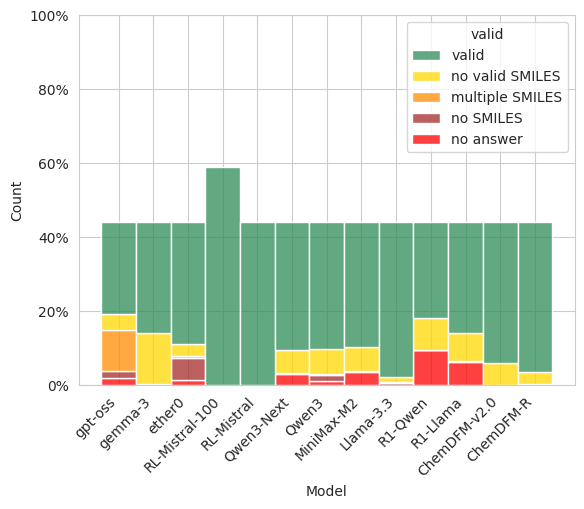

In [25]:
cmap = {
    "valid": "seagreen",
    "no valid SMILES": "gold",
    "multiple SMILES": "darkorange",
    "no SMILES": "brown",
    "no answer": "red"
}

ax = sns.histplot(data=df, x="Model", hue="valid", multiple="stack", stat="count", palette= cmap, hue_order=list(cmap.keys()))
# rotate x labels
max_count = 128_000
ax.set_ylim(0, max_count)

yticks = np.linspace(0, max_count, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(y / max_count * 100)}%" for y in yticks])
_ = plt.xticks(rotation=45, ha='right')
# Replace y_ticks with percentages from 0 to 100

plt.savefig(f"{FIG_PATH}/validity.pdf", bbox_inches='tight')

# Uniqueness and Diversity Metrics

## Computations

Compute the uniqueness of the generated smiles in each prompt

In [26]:
uniq_df = df[df.validity == 1].groupby(["Model", "prompt_id"]).agg(
    **{f"{k}":pd.NamedAgg(column="smiles", aggfunc=aggregate_molgen_fn("uniqueness", k)) for k in list(range(1,100,10))}
).reset_index()
uniq_df = uniq_df.melt(id_vars=["Model"], value_vars=[str(k) for k in list(range(1,100,10))], var_name="n_rollout")
uniq_df["n_rollout"] = uniq_df["n_rollout"].apply(int)

Diversity in each prompt (ecfp4)

In [27]:
fp_fn = fp_name_to_fn("ecfp4-2048")
sub_df = df[
    (df.validity == 1) & (df.prompt_id.isin(sub_sample_prompts))
].drop_duplicates(subset=["prompt_id", "smiles"])
sub_df["fps"] = sub_df["smiles"].progress_apply(lambda x: fp_fn(Chem.MolFromSmiles(x)))

sim_df = sub_df.groupby(["Model", "prompt_id"]).agg(
    **{
        f"{k}":pd.NamedAgg(
            column="fps",
            aggfunc=aggregate_molgen_fn("diversity",k, is_fp=True))
        for k in [50]
    }
).reset_index()
sim_df = sim_df.melt(id_vars=["Model"], value_vars=[str(k) for k in [50]], var_name="n_rollout")
sim_df["n_rollout"] = sim_df["n_rollout"].apply(int)


100%|██████████| 390736/390736 [00:50<00:00, 7680.91it/s]


Uniqueness accross prompts

In [28]:
uniqueness_ac_prompts = []

def topk_fn(k):
    def get_topk(x):
        return list(np.pad(x, (0, 100), 'constant', constant_values=None)[:k])
    return get_topk

def avg_prompt_occurrence(smiles_lists):
    n_prompts = len(smiles_lists)
    if n_prompts == 0:
        return np.nan

    # Count in how many prompts each SMILES appears
    smiles_prompt_counts = {}
    for smiles_list in smiles_lists:
        # Get unique SMILES in this prompt (avoid counting duplicates within same prompt)
        unique_in_prompt = set(s for s in smiles_list if s is not None)
        for smi in unique_in_prompt:
            smiles_prompt_counts[smi] = smiles_prompt_counts.get(smi, 0) + 1

    if len(smiles_prompt_counts) == 0:
        return np.nan

    # Calculate the proportion of prompts each SMILES appears in
    proportions = [count for count in smiles_prompt_counts.values()]

    # Return the average proportion
    return np.mean(proportions)

for k in tqdm(range(2,101,10)):
    smiles_per_p = df[df.validity == 1].groupby(
        ["Model", "prompt_id"]
    ).smiles.apply(topk_fn(k)).reset_index()

    uniqueness_ac_prompts.append(
        smiles_per_p.groupby("Model").smiles.apply(
            avg_prompt_occurrence
        ).reset_index().rename(columns={"smiles":str(k)})
    )

uniq_ap_df = pd.concat(
    [sdf.set_index("Model") for sdf in uniqueness_ac_prompts], axis = 1
).reset_index().melt(id_vars=["Model"], value_vars=[str(k) for k in range(2,101,10)], var_name="n_rollout")
uniq_ap_df["n_rollout"] = uniq_ap_df["n_rollout"].apply(int)


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


## Plots

In [29]:
from notebooks.utils import CMAP_MODELS

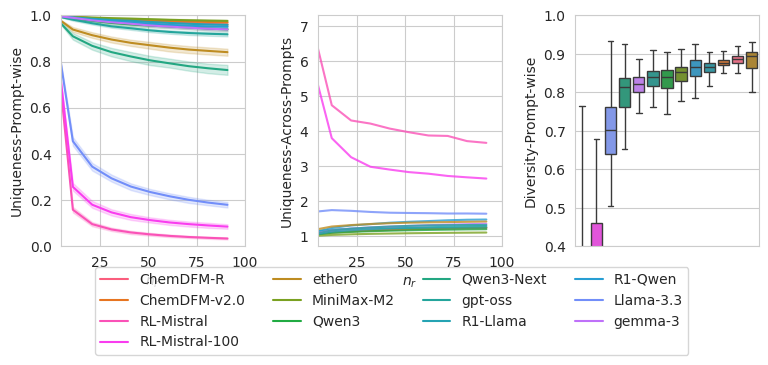

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(9,3), sharey=False, gridspec_kw={"wspace":0.4})

ax = axes[0]
sns.lineplot(uniq_df, x="n_rollout", y="value", hue="Model", ax=ax, legend=True, palette=CMAP_MODELS, hue_order=CMAP_MODELS.keys())
ax.set_ylabel("Uniqueness-Prompt-wise")
ax.set_xlabel("$n_r$")
ax.set_ylim(0,1)
ax.set_xlim(5,100)
# Move legend below plot
ax.legend(bbox_to_anchor=(1.8, -.5), loc='lower center', ncols=4)

ax = axes[1]
sns.lineplot(uniq_ap_df, x="n_rollout", y="value", hue="Model", ax=ax, legend = False, palette=CMAP_MODELS, alpha=0.8)
ax.set_ylabel("Uniqueness-Across-Prompts")
# ax.set_ylim(0.,1)
ax.set_xlim(5,100)
ax.set_xlabel("$n_r$")

ax = axes[2]
x_order = sim_df.groupby("Model")["value"].median().sort_values().index.tolist()
sns.boxplot(sim_df, x="Model", y="value", hue="Model", ax=ax, legend = False, order=x_order, palette=CMAP_MODELS,fliersize=0)
ax.set_ylabel("Diversity-Prompt-wise")
ax.set_xlabel("")
ax.set_xticklabels([],)
ax.set(ylim=(0.4,1))

fig.savefig(f"{FIG_PATH}/uniqueness_diversity.pdf", bbox_inches='tight')


# Top-k scores

In [31]:
k_values = [1, 5, 10]
topk_dfs = []
n_div_k = {
    k:  list(range(1, min(10,128 // k))) for k in k_values
}
pbar = tqdm(total=sum(len(v) for v in n_div_k.values()))

for k in k_values:
    roll_values = [v * k for v in n_div_k[k]]
    k_topk_dfs = []
    for roll in roll_values:
        topdf = df.groupby(
            ["Model", "prompt_id"]
        ).apply(
            aggregate_molgen_fn("topk", k=k, n_rollout=roll)
        ).to_frame().rename(columns={0:f"{roll}"}).reset_index()
        k_topk_dfs.append(
            topdf
        )
        pbar.update(1)

    topk_df = pd.concat(k_topk_dfs).reset_index(drop=True)
    topk_df["k"] = k
    topk_df = topk_df.melt(id_vars=["prompt_id","Model", "k"], value_vars=[str(k) for k in roll_values], var_name="n_rollout", value_name= "top-k")
    topk_df["n_rollout"] = topk_df["n_rollout"].apply(int)

    topk_dfs.append(topk_df)
pbar.close()
topk_df = pd.concat(topk_dfs).reset_index(drop=True)

topk_df["$n_r$ / k"] = topk_df["n_rollout"] / topk_df["k"]


100%|██████████| 117/117 [07:51<00:00,  4.03s/it]

100%|██████████| 27/27 [01:35<00:00,  3.52s/it]


In [32]:
from notebooks.utils import CMAP_MODELS, MARKER_MODELS

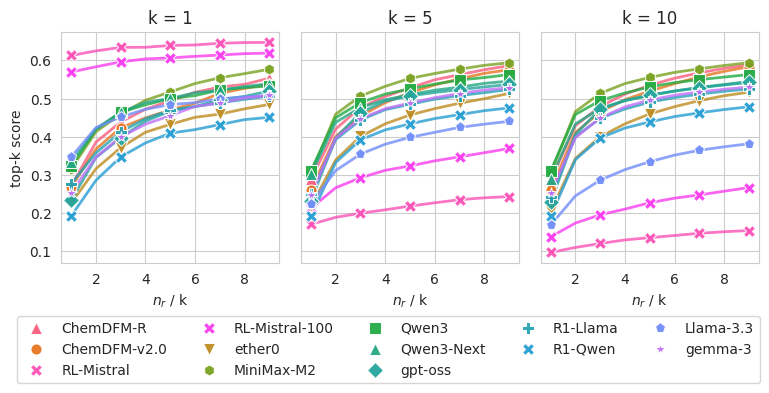

In [37]:
fig,axes = plt.subplots(
    1,
    topk_df.k.nunique(),
    figsize=(3 * topk_df.k.nunique(),3),
    sharey=True,
    gridspec_kw={"wspace":0.1 }
)

for k, ax in zip(topk_df.k.unique(), axes):
    sns.lineplot(
        topk_df[
            topk_df.k == k
        ],
        x="$n_r$ / k",
        y="top-k",
        hue="Model",
        ax=ax,
        legend = False,
        palette=CMAP_MODELS,
        hue_order=CMAP_MODELS.keys(),
        alpha = .8,
        linewidth = 2,
        errorbar=None,
    )
    sns.lineplot(
        topk_df[
            (topk_df.k == k) & (topk_df["$n_r$ / k"] % 2 == 1)
        ],
        x="$n_r$ / k",
        y="top-k",
        hue="Model",
        ax=ax,
        legend = k==topk_df.k.max(),
        palette=CMAP_MODELS,
        hue_order=CMAP_MODELS.keys(),
        alpha = .95,
        linewidth = 0,
        errorbar=None,
        markers=MARKER_MODELS,
        style="Model", # Different markers for each model
        markersize=8,
        dashes=False,
    )
    ax.set_ylabel("top-k score")
    ax.set_title(f"k = {k}")
# Move legend of the last axis below plot
axes[-1].legend(bbox_to_anchor=(-0.7, -0.55), loc='lower center', ncols=5)

fig.savefig(f"{FIG_PATH}/topk_k_score.pdf", bbox_inches='tight')

# Tables for Top-k

In [38]:
from notebooks.metadata.molgen import MODEL_META
LATEX_PATH = "MolGenDocking-latex/tables/results"

In [39]:
# Create table with: model_name, size, metric_name, value
import re

ROLLOUTS_AT_K = {
    1: [1, 5, 10],
    # 2: [2, 20],
    10: [10, 50, 100],
    25: [25, 50, 100],
}

table = pd.DataFrame(columns=["model", "Size", "Think.", "Metric", r"$n_\text{rollouts}$", "Value"])
size_pattern = re.compile(r'(?i)(?:^|[-_])(\d+\s*[b])(?:$|[-_])')
pbar = tqdm(total=len(df.model.unique())*sum([len(ROLLOUTS_AT_K[k]) for k in ROLLOUTS_AT_K]))

for model_name in df.model.unique():
    assert any([m in model_name for m in MODEL_META.keys()]), f"Model {model_name} not found in MODEL_META"
    key = [m for m in MODEL_META.keys() if m in model_name][0]
    metadata = MODEL_META[key]
    for k in ROLLOUTS_AT_K:
        for n_rollout in ROLLOUTS_AT_K[k]:
            sub_df = df[df.model == model_name]
            # sub_df = sub_df.drop_duplicates(subset=["prompt_id", "smiles"])
            pass_k = sub_df.groupby("prompt_id").apply(
                aggregate_molgen_fn("topk",k=k, n_rollout=n_rollout)
            ).to_frame().rename(columns={0:str(k)}).reset_index()
            if not "size" in metadata:
                try:
                    size = size_pattern.search(model_name).group(1).upper()
                except:
                    raise ValueError(f"Size not found for model {model_name}")
            else:
                size = metadata["size"]
            for i, row in pass_k.iterrows():
                thinking = r"\CheckmarkBold" if metadata["thinking"] else r"\XSolidBrush"
                chem = r"\CheckmarkBold" if metadata["Chem."] else r"\XSolidBrush"

                table.loc[len(table)] = [
                    model_name,
                    size,
                    thinking,
                    # chem,
                    f"top-{k}, $n_r$:",
                    n_rollout,
                    row[str(k)]
                ]
            pbar.update(1)


100%|██████████| 117/117 [01:48<00:00,  1.31s/it]

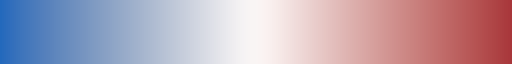

In [40]:
from notebooks.utils.utils import process_model_name

MODEL_ORDER = [
    "MiniMax-M2",
    "Qwen3",
    "Qwen3-Next",
    "gpt-oss",
    "R1-Llama",
    "R1-Qwen",
    "gemma-3",
    "Llama-3.3",
    "RL-Mistral",
    "RL-Mistral-100",
    "ChemDFM-R",
    "ether0",
    "ChemDFM-v2.0",
]

table["N_rolls"] = table[r"$n_\text{rollouts}$"].apply(lambda x: str(x))
table["Model"] = table["model"].apply(process_model_name)
table[r"\makecell{\rotatebox{90}{Thinking}}"] = table["Think."]
table[r"\makecell{\rotatebox{90}{Size (B)}}"] = table["Size"].apply(lambda x: str(x).replace("B", ""))

cmap = sns.color_palette("vlag", as_cmap=True)
cmap

In [42]:
from notebooks.utils import PandasTableFormatter

def color_map(val: float) -> str:
    "Returns a color based on the value (eg '#FF5733')"
    val = np.clip(val, -0.3, 0.7)
    color = cmap(val)
    return f"rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})"

formatter = PandasTableFormatter(
    n_decimals = 2, # Number of decimals to keep in the table
    aggregation_methods=["mean"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False, # Whether to compute global aggregation across all columns (True)
    color_mapping =color_map
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", r"\makecell{\rotatebox{90}{Size (B)}}", r"\makecell{\rotatebox{90}{Thinking}}"], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["textbf:--rwrap--latex; underline:--rwrap--latex", "underline:--rwrap--latex",], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(
    style, f"{LATEX_PATH}/gen_table.tex", 0, multicol_align="c", hrules=True,
)
style

Model
\makecell{\rotatebox{90}{Size (B)}}
\makecell{\rotatebox{90}{Thinking}}


In [43]:
formatter = PandasTableFormatter(
    n_decimals = 2, # Number of decimals to keep in the table
    aggregation_methods=["mean", "std"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model",], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;", "text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny " + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
col_sep = "c|"  + "|p{0.4cm}p{0.3cm}" * table.groupby(["Metric", r"N_rolls"]).ngroups
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table_std.tex", col_sep, multicol_align="|c|", hrules=True, n_first_cols=2)